<a href="https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/ml_playground5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -f data/*
!wget -nv -P data https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_11_Support_Vector_Machines/linear.csv
!wget -nv -P data https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_11_Support_Vector_Machines/one_circle.csv
!wget -nv -P data https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_11_Support_Vector_Machines/two_circles.csv
!ls -al data
!wc -l data/*.csv

2025-03-11 03:59:04 URL:https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_11_Support_Vector_Machines/linear.csv [2617/2617] -> "data/linear.csv" [1]
2025-03-11 03:59:04 URL:https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_11_Support_Vector_Machines/one_circle.csv [4820/4820] -> "data/one_circle.csv" [1]
2025-03-11 03:59:04 URL:https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_11_Support_Vector_Machines/two_circles.csv [9726/9726] -> "data/two_circles.csv" [1]
total 32
drwxr-xr-x 2 root root 4096 Mar 11 03:59 .
drwxr-xr-x 1 root root 4096 Mar 11 03:59 ..
-rw-r--r-- 1 root root 2617 Mar 11 03:59 linear.csv
-rw-r--r-- 1 root root 4820 Mar 11 03:59 one_circle.csv
-rw-r--r-- 1 root root 9726 Mar 11 03:59 two_circles.csv
   61 data/linear.csv
  111 data/one_circle.csv
  221 data/two_circles.csv
  393 total


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import torch

# Some functions to plot our points and draw the lines
# Some functions to plot our points and draw the lines
def plot_points(features, labels, point_size=25, ax=None):
  X = np.array(features)
  y = np.array(labels)
  spam = X[np.argwhere(y==1)]
  ham = X[np.argwhere(y==0)]
  if ax is None:
    p=plt
    p.xlabel('aha')
    p.ylabel('boo')
  else:
    p=ax
    p.set_xlabel('aha')
    p.set_ylabel('boo')
  p.scatter([s[0][0] for s in spam],
            [s[0][1] for s in spam],
            s = point_size,
            color = 'cyan',
            edgecolor = 'k',
            marker = '^')
  p.scatter([s[0][0] for s in ham],
            [s[0][1] for s in ham],
            s = point_size,
            color = 'red',
            edgecolor = 'k',
            marker = 's')
  p.legend(['happy','sad'])

# f = lambda x: int(x[1]>x[0])
# def g(Z):
#   return np.array([f(i) for i in Z])
def plot_keras_model(X, y, model, ax=None):
  X = np.array(X)
  y = np.array(y)
  plot_step = 0.01
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                       np.arange(y_min, y_max, plot_step))
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  if ax is None:
    plt.contour(xx, yy, Z, colors = 'k',linewidths = 1, levels=0)
    plot_points(X, y)
    plt.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=range(-1,2))
    plt.show()
  else:
    ax.contour(xx, yy, Z, colors = 'k',linewidths = 1, levels=0)
    plot_points(X, y, ax=ax)
    ax.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=range(-1,2))

def plot_torch_model(X, y, model, ax=None):
  X = np.array(X)
  y = np.array(y)
  plot_step = 0.2
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))
  Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
  Z = Z.reshape(xx.shape)
  if ax is None:
    plt.contour(xx, yy, Z, colors = 'k',linewidths = 1, levels=0)
    plot_points(X, y)
    plt.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=range(-1,2))
    plt.show()
  else:
    ax.contour(xx, yy, Z, colors = 'k',linewidths = 1, levels=0)
    plot_points(X, y, ax=ax)
    ax.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=range(-1,2))

# SVM
Support Vector Machine - line that is as far from the points as possible in a discrete classifier.

To train an SVM, we need to build an error function for a classifier consisting of two (paralell) lines, spaced as far apart as possible.
1. Each of the two lines should classify the points as best as possible
2. The two lines should be as far away from each other as possible

Hence, the error function can look like this: Error = classification error + distance error
* classification error function: sum of |score1|+|score2| where score1 and 2 are the score of each line, respectively (i.e. $|W\cdot X+b_1| + |W\cdot X+b_2|$ for linear classifier)
* the perpandicular distance between 2 paralell lines $w_1x_1+w_2x_2+b_1=0$ and $w_1x_1+w_2x_2+b_1=0$ is $\frac{2}{\sqrt{w_1^2+w_2^2}}$. i.e. dot product of W: $\frac{n}{\sqrt{W\cdot W}}$, where $n$ is dim of W. The bigger the distance, the better the classifier.

Do we want the SVM to focus more on classification or distance? the *C parameter* (C=1 same focus on each; C>1 more on classification; C<1 more on distance): $Error = C(ClassifierError)+DistanceError$

## Linear example

In [3]:
df = pd.read_csv('data/linear.csv')
df[:10]

,Unnamed: 0,x_1,x_2,y
0,0,-2.921542,-2.924093,0
1,1,0.136782,0.540402,1
2,2,2.747296,1.547237,1
3,3,-2.780707,-2.673131,0
4,4,2.030421,1.329452,1
5,5,-0.314170,-2.591670,0
6,6,-1.896219,-0.516953,0
7,7,1.432148,0.841080,1
8,8,0.885989,2.424742,1
9,9,-2.634456,1.428708,0


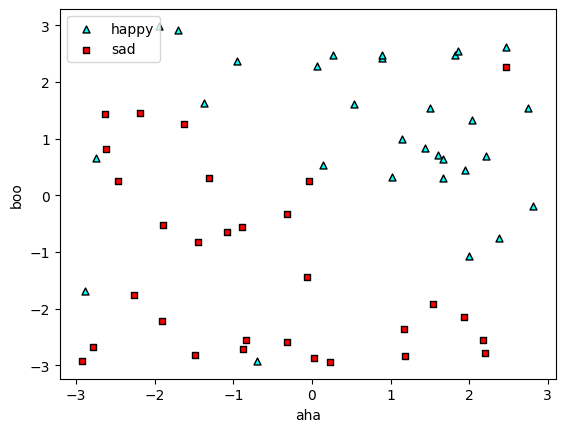

In [4]:
features = df[['x_1', 'x_2']]
labels = df['y']
plot_points(features, labels)

Accuracy: (C=1) 0.9333333333333333
Accuracy: (C=0.01) 0.8666666666666667
Accuracy: (C=100) 0.9166666666666666


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'C=100\nAccuracy: 0.9167')

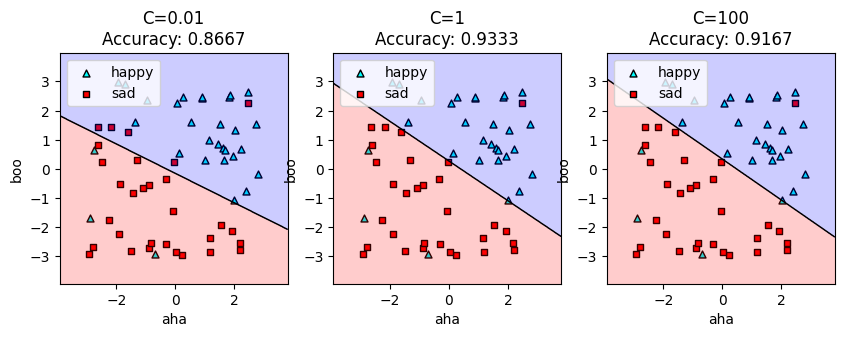

In [5]:
from sklearn.svm import SVC

svm_linear = SVC(kernel='linear')
svm_linear.fit(features, labels)
print('Accuracy: (C=1)', svm_linear.score(features, labels))

svm_linear_001 = SVC(kernel='linear', C=0.01)
svm_linear_001.fit(features, labels)
print('Accuracy: (C=0.01)', svm_linear_001.score(features, labels))

svm_linear_100 = SVC(kernel='linear', C=100)
svm_linear_100.fit(features, labels)
print('Accuracy: (C=100)', svm_linear_100.score(features, labels))

# f = lambda x: int(x[1]>x[0])
# def g(Z):
#   return np.array([f(i) for i in Z])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
plot_keras_model(features, labels, svm_linear_001, ax1)
plot_keras_model(features, labels, svm_linear, ax2)
plot_keras_model(features, labels, svm_linear_100, ax3)
ax1.set_title(f'C=0.01\nAccuracy: {svm_linear_001.score(features, labels):.4f}')
ax2.set_title(f'C=1\nAccuracy: {svm_linear.score(features, labels):.4f}')
ax3.set_title(f'C=100\nAccuracy: {svm_linear_100.score(features, labels):.4f}')

## Kernel Method

A kernel is a similarity function, i.e. to tell us if 2 points are similar or different (e.g. close or far).

Kernel gives rise to *feature map*: map between dataset's space and a higher dimensional space.

In our example, we look at adding columns (features / dimensions) to our dataset to make the points separatable.
* polynomial kernal: model data using polynomials such as circle, parabola, hyperbola
* radial basis functions (RBF) kernel

### Polynomial kernel

   Unnamed: 0       x_1       x_2  y
0           0 -0.759416  2.753240  0
1           1 -1.885278  1.629527  0
2           2  2.463302 -1.023869  0
3           3 -1.986004 -0.898810  0
4           4  2.010834 -2.580117  0
5           5  2.410188  2.370501  0
6           6  1.599140 -0.862732  0
7           7 -1.109856 -2.469697  0
8           8  2.447342  2.811180  0
9           9 -1.697732  2.539848  0


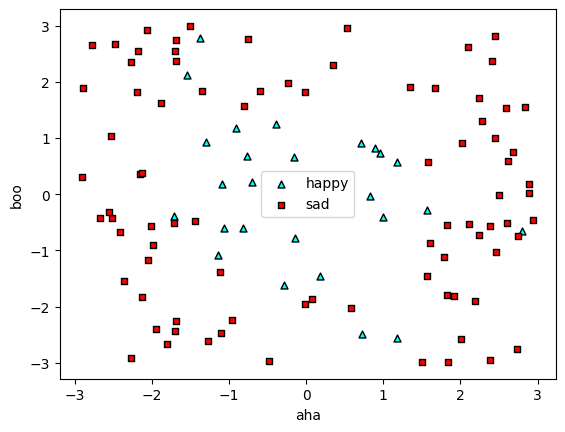

In [6]:
df = pd.read_csv('data/one_circle.csv')
print(df[:10])
features = df[['x_1', 'x_2']]
labels = df['y']
plot_points(features, labels)

     Unnamed: 0       x_1       x_2  y       circ
0             0 -0.759416  2.753240  0   8.157044
1             1 -1.885278  1.629527  0   6.209630
2             2  2.463302 -1.023869  0   7.116166
3             3 -1.986004 -0.898810  0   4.752072
4             4  2.010834 -2.580117  0  10.700460
..          ...       ...       ... ..        ...
105         105 -1.376637  2.778703  1   9.616323
106         106 -0.703722  0.215382  1   0.541614
107         107  0.729767 -2.479655  1   6.681248
108         108 -1.715920 -0.393404  1   3.099148
109         109  2.382873 -2.951074  0  14.386922

[110 rows x 5 columns]


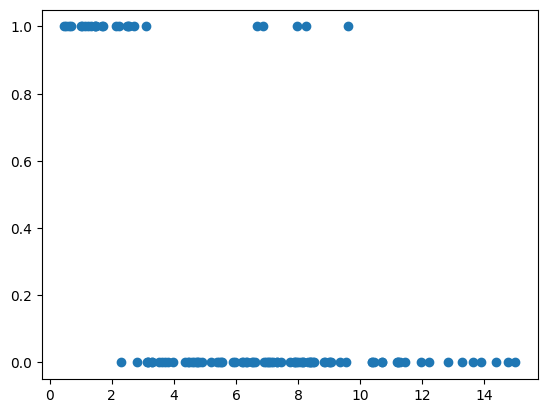

In [7]:
# add another column for x_1^2 + x_2^2
df['circ'] = df['x_1']**2 + df['x_2']**2
print(df)
plt.scatter(df['circ'], df['y'])

Using a kernel of degree two on the 2-D features will map it into 5-D space:
$[x_1, x_2] \longrightarrow [x_1, x_2, x_1^2, x_1x_2, x_2^2]$

If the feature dataset is 3D, then degree 2 kernel will map it into 9D.

If the feature dataset is 2D, then a degree 3 kernel will map it into 9-D.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'degree=4\nAccuracy=0.9')

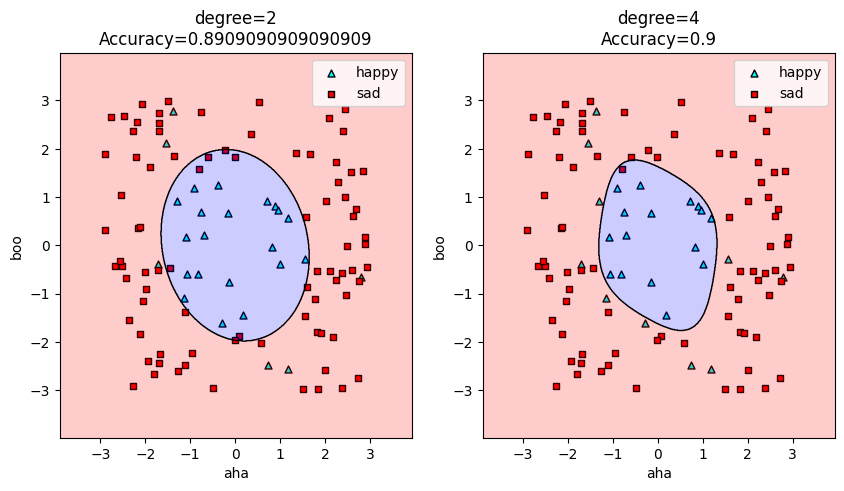

In [8]:
from sklearn.svm import SVC

svm_d2 = SVC(kernel='poly', degree=2)
svm_d2.fit(features, labels)

svm_d4 = SVC(kernel='poly', degree=4)
svm_d4.fit(features, labels)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
plot_keras_model(features, labels, svm_d2, ax1)
plot_keras_model(features, labels, svm_d4, ax2)
ax1.set_title(f'degree=2\nAccuracy={svm_d2.score(features, labels)}')
ax2.set_title(f'degree=4\nAccuracy={svm_d4.score(features, labels)}')

### Radial basis function (RBF)

We create mountain or valley at each point. Such function is called raial basis function (RMF) because the value of the function is only dependent on the distance between the point and the center (of the peak or valley)

For single variable x, the RBF is $y=e^{-x^2}$

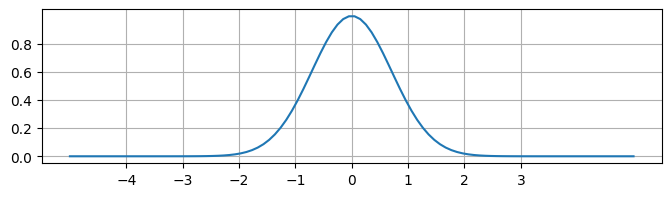

In [9]:
x=np.linspace(-5,5,100)
plt.figure(figsize=(8,2))
plt.plot(x, np.exp(-x**2))
plt.gca().set_xticks(np.arange(-4, 4, 1))
plt.gca().set_yticks(np.arange(0, 1, 0.2))
plt.grid(True)

Note that the bump is at 0. To translate the bump to any point p, we $y=e^{-(x-p)^2}$

For 2 variables x and y the RBF: $z=e^{-(x^2+y^2)}$

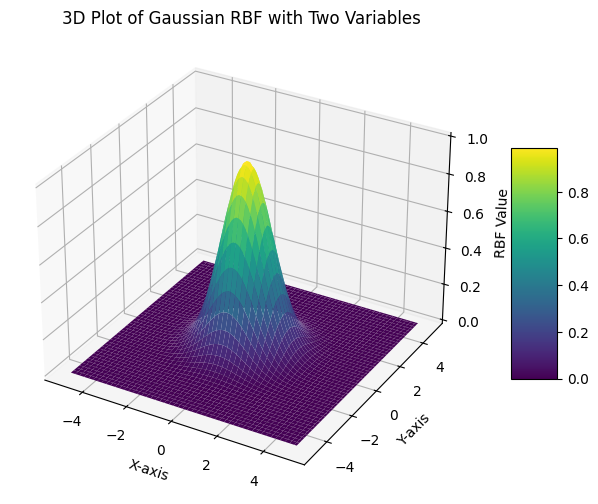

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the Gaussian RBF function
def gaussian_rbf(x, y, center_x=0, center_y=0, sigma=1):
    return np.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * sigma**2))

# Generate a grid of points in the 2D space
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
x, y = np.meshgrid(x, y)

# Compute the RBF values for each point in the grid
z = gaussian_rbf(x, y)

# Create a 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(x, y, z, cmap='viridis')

# Add labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('RBF Value')
ax.set_title('3D Plot of Gaussian RBF with Two Variables')

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Display the plot
plt.show()

To generalise, for n-variables, the RBF
$$y=e^{-(x_1^2+x_2^2+\ldots+x_n^2)}
$$

To translate the n-dim bump from center to point (p1, ... pn):
$$y=e^{-[(x_1-p_1)^2+(x_2-p_2)^2+\ldots+(x_n-p_n)^2]}
$$

To measure how close two points are: **similarity**. Similarity between two points p and q:
$similarity(p,q)=e^{-distance(p,q)^2}$

This is basically the height of the RMF centered at point p applied at point q. i.e. the higher the similarity, the closer q is to p.

The similarity between point and itself is 1. Similarity is also symetrical.

### RBF gamma parameter
To change underfitting/overfitting model, we want to tune the wideness of the RBF curve, this is where gamma hyperparameter is used.

* Small gamma -> wide/smooth RBF curve
* large gamma -> narrow/spiky RBF curve

$$y=e^{-\gamma[(x_1-p_1)^2+\ldots+(x_n-p_n)^2]}
$$

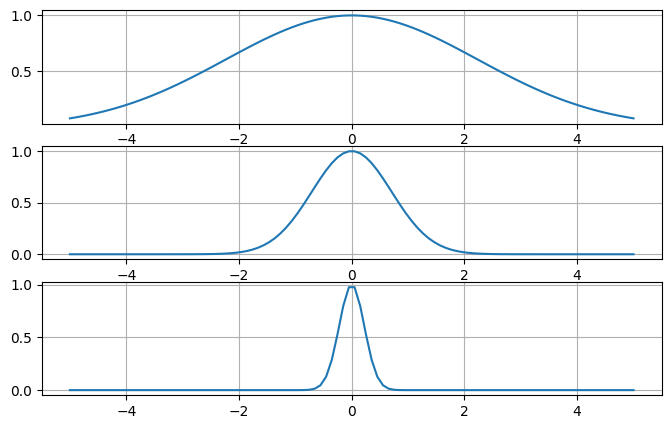

In [11]:
gammas = [0.1, 1.0, 10.]
x=np.linspace(-5,5,100)

fig, axes = plt.subplots(3,1, figsize=(8,5))
axes = axes.flatten()

for i, gamma in enumerate(gammas):
  ax = axes[i]
  ax.plot(x, np.exp(-gamma*x**2))
  ax.grid(True)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


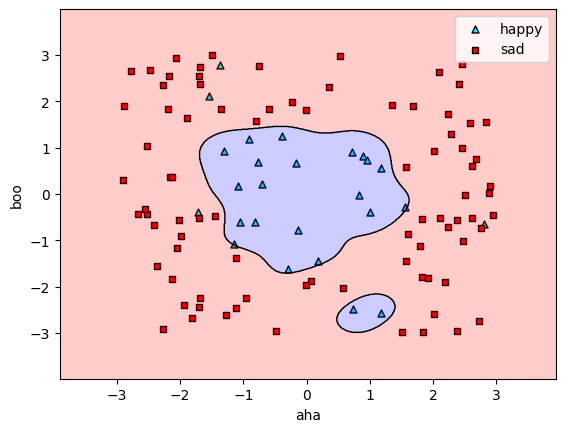

In [12]:
svm_rbf = SVC(kernel='rbf', gamma=3)
svm_rbf.fit(features, labels)
plot_keras_model(features, labels, svm_rbf)

   Unnamed: 0       x_1       x_2  y
0           0  0.271606 -1.119853  1
1           1  1.681520  0.120557  1
2           2 -1.509630  2.542006  0
3           3 -0.631786  0.538599  1
4           4 -0.684341 -0.730527  1
5           5  2.583157  2.485508  0
6           6  0.939163 -2.623075  0
7           7  0.346455 -2.845115  0
8           8 -0.692584  1.168538  1
9           9  0.931412 -1.860714  0


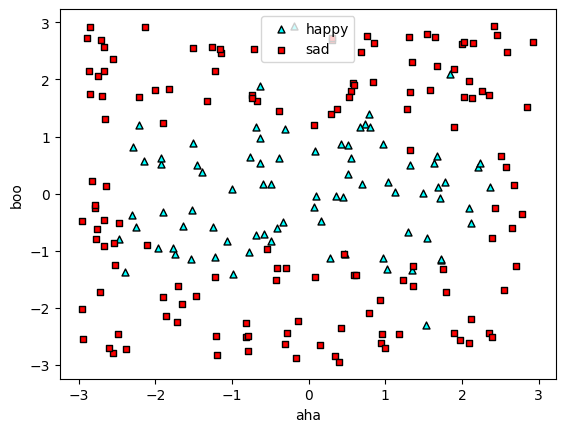

In [13]:
df = pd.read_csv('data/two_circles.csv')
print(df[:10])
features = df[['x_1', 'x_2']]
labels = df['y']
plot_points(features, labels)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


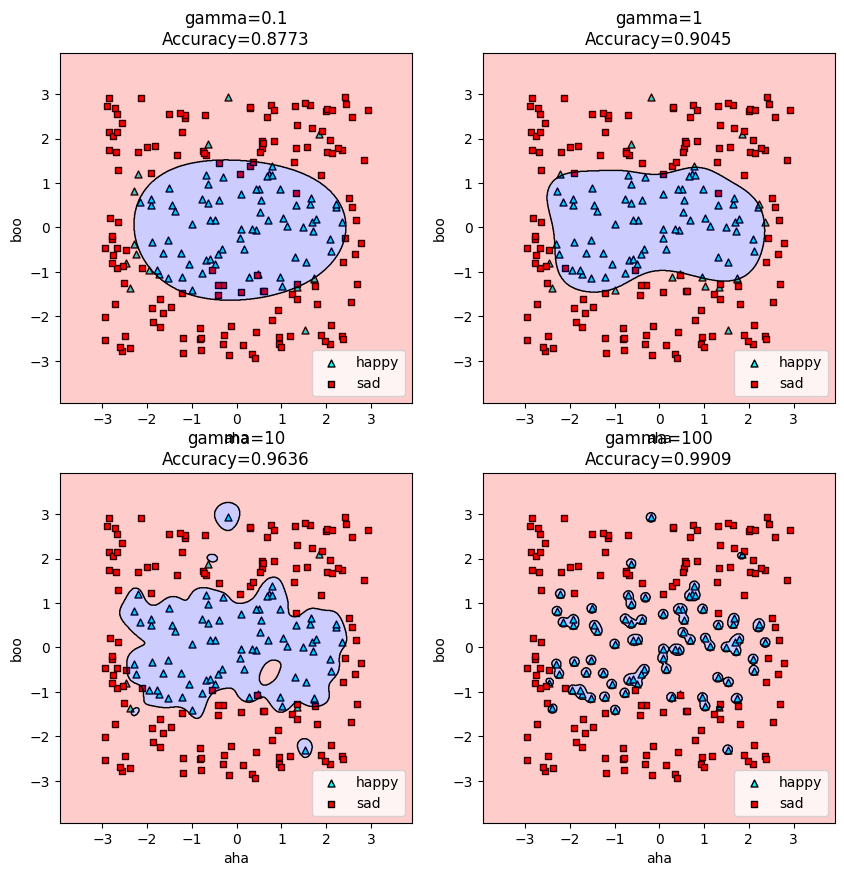

In [14]:
gammas = [0.1, 1, 10, 100]
svm_rbfs=[]
for gamma in gammas:
  svm_rbf2 = SVC(kernel='rbf', gamma=gamma)
  svm_rbf2.fit(features, labels)
  svm_rbfs.append(svm_rbf2)

ncols=2
nrows=len(gammas)//ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(10,10))
axes = axes.flatten()
for i in range(len(gammas)):
  ax=axes[i]
  model = svm_rbfs[i]
  plot_keras_model(features, labels, model, ax)
  ax.set_title(f'gamma={gammas[i]}\nAccuracy={model.score(features, labels):.4f}')
